In [1]:
import cv2

import os

import math

from time import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

from tqdm.auto import tqdm

import itertools

import random

import re

import sys
sys.path.append("./lib/")

from utils import GradualWarmupScheduler
from models import FeaturesModelPt9v2BN, FeaturesModelPt7v2BN, GlanceModelGSv1

In [2]:
# Some constans 
img_sz = 32  # Size of input image
batch_size = 256

num_workers = 6

In [3]:
logs = []

def print_l(s):
    logs.append(s)
    print(s)

In [4]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, 4, padding_mode='reflect'),
        transforms.RandomChoice([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
            transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
            transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
            transforms.TrivialAugmentWide(),
            transforms.RandomCrop(32, 4, padding_mode='reflect')
        ]),        
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True)

Files already downloaded and verified


In [5]:
model = GlanceModelGSv1(
    FeaturesModelPt9v2BN,
    img_sz=img_sz,
    inp_channels=3,
    num_classes=10,
    f_sz=128,
    p_sz=32,
    h_sz=512,
    layers_num=2,
    steps=5,
    r_dropout=0, #0.25
    is_full_train=True
)

In [6]:
device = torch.device('cuda:0')

In [7]:
model.to(device);

In [8]:
sum([p.numel() for p in model.parameters()])

5102570

In [9]:
sum([p.numel() for p in model.features_model_g.parameters()])

299520

In [10]:
sum([p.numel() for p in model.separate_parameters(no_decay=False)])

5079296

In [11]:
sum([p.numel() for p in model.separate_parameters(no_decay=True)])

23274

In [12]:
hard = True
tau = 1.0
add_gumbels = True
debug = False

epochs = 75
wup_mult = 8.0
wup_epochs = 5

full_train_cycles = 2

In [13]:
for c in range(10):
    optimizer = optim.AdamW(
        [
            {'params': model.separate_parameters(no_decay=False)},
            {'params': model.separate_parameters(no_decay=True), 'weight_decay': 0}
        ],
        lr=0.001/wup_mult, 
        weight_decay=0.1
    )        

    model.choice_model[1].weight.data /= min(2.0, model.choice_model[1].weight.data.abs().max())

    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=wup_mult, total_epoch=wup_epochs, after_scheduler=cosine_scheduler)

    loss_stat = []

    for e in tqdm(range(0, epochs)):
        for is_train in [True, False]:
            all_losses, all_preds, all_targets = [], [], []

            model.train(is_train)

            with torch.set_grad_enabled(is_train):
                for imgs, target, *_ in (train_loader if is_train else test_loader):

                    imgs, target = [v.to(device) for v in (imgs, target)]

                    tau = max(1.0, (epochs - e) / 10.0)
                    # It feature extractors are not pretrained, train them on whole images for the first full_train_cycles
                    is_full_train = c < full_train_cycles
                    
                    logits = model(
                        imgs, 
                        is_train=is_train, 
                        hard=hard, 
                        tau=tau, 
                        add_gumbels=add_gumbels and is_train,
                        is_full_train=is_full_train
                    )
                    
                    if is_train and is_full_train:
                        loss = F.cross_entropy(logits[0], target) + F.cross_entropy(logits[1], target)
                        logits = logits[0]
                    else:
                        loss = F.cross_entropy(logits, target)
                    
                    all_losses.append(loss.item())
                    all_preds.extend(logits.argmax(-1).detach().cpu().numpy().tolist())
                    all_targets.extend(target.cpu().numpy().tolist())

                    if is_train:
                        loss.backward()
                        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        # torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
                        loss_stat.append(loss.item())
                        optimizer.step()
                        optimizer.zero_grad()

            all_losses, all_preds, all_targets = \
                [np.array(n) for n in [all_losses, all_preds, all_targets]]

            acc = (all_preds == all_targets).mean()

            print_l(f"{f'{e:03d}.' if is_train else '    '} {'train' if is_train else ' test'} loss: {all_losses.mean():.04f}, acc: {acc:.04f}, lr: {optimizer.param_groups[0]['lr']:.06f}")

        scheduler.step()

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 3.9833, acc: 0.2452, lr: 0.000125
      test loss: 1.7733, acc: 0.3467, lr: 0.000125
001. train loss: 3.3625, acc: 0.3512, lr: 0.000300
      test loss: 1.4354, acc: 0.4718, lr: 0.000300
002. train loss: 2.9949, acc: 0.4155, lr: 0.000475
      test loss: 1.4216, acc: 0.4970, lr: 0.000475
003. train loss: 2.7884, acc: 0.4514, lr: 0.000650
      test loss: 1.2755, acc: 0.5454, lr: 0.000650
004. train loss: 2.6280, acc: 0.4770, lr: 0.000825
      test loss: 1.2274, acc: 0.5588, lr: 0.000825
005. train loss: 2.5028, acc: 0.4979, lr: 0.001000
      test loss: 1.1455, acc: 0.5903, lr: 0.001000


/home/ruslan/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


006. train loss: 2.3370, acc: 0.5234, lr: 0.001000
      test loss: 1.1011, acc: 0.6071, lr: 0.001000
007. train loss: 2.2251, acc: 0.5443, lr: 0.001000
      test loss: 1.0422, acc: 0.6244, lr: 0.001000
008. train loss: 2.1300, acc: 0.5592, lr: 0.000998
      test loss: 1.0122, acc: 0.6389, lr: 0.000998
009. train loss: 2.0650, acc: 0.5713, lr: 0.000996
      test loss: 0.9457, acc: 0.6627, lr: 0.000996
010. train loss: 2.0014, acc: 0.5792, lr: 0.000993
      test loss: 0.9145, acc: 0.6772, lr: 0.000993
011. train loss: 1.9577, acc: 0.5871, lr: 0.000989
      test loss: 0.9150, acc: 0.6774, lr: 0.000989
012. train loss: 1.9001, acc: 0.5996, lr: 0.000984
      test loss: 0.8608, acc: 0.6908, lr: 0.000984
013. train loss: 1.8516, acc: 0.6056, lr: 0.000979
      test loss: 0.8358, acc: 0.7021, lr: 0.000979
014. train loss: 1.7882, acc: 0.6185, lr: 0.000972
      test loss: 0.8526, acc: 0.6896, lr: 0.000972
015. train loss: 1.7932, acc: 0.6167, lr: 0.000965
      test loss: 0.8185, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.8909, acc: 0.7872, lr: 0.000125
      test loss: 0.4957, acc: 0.8270, lr: 0.000125
001. train loss: 0.9459, acc: 0.7750, lr: 0.000300
      test loss: 0.5165, acc: 0.8185, lr: 0.000300
002. train loss: 1.0435, acc: 0.7576, lr: 0.000475
      test loss: 0.5502, acc: 0.8084, lr: 0.000475
003. train loss: 1.1009, acc: 0.7459, lr: 0.000650
      test loss: 0.5824, acc: 0.7951, lr: 0.000650
004. train loss: 1.1826, acc: 0.7287, lr: 0.000825
      test loss: 0.5946, acc: 0.7950, lr: 0.000825
005. train loss: 1.2504, acc: 0.7204, lr: 0.001000
      test loss: 0.6073, acc: 0.7859, lr: 0.001000
006. train loss: 1.2647, acc: 0.7179, lr: 0.001000
      test loss: 0.6418, acc: 0.7749, lr: 0.001000
007. train loss: 1.2575, acc: 0.7183, lr: 0.001000
      test loss: 0.6457, acc: 0.7668, lr: 0.001000
008. train loss: 1.2536, acc: 0.7181, lr: 0.000998
      test loss: 0.6209, acc: 0.7799, lr: 0.000998
009. train loss: 1.2501, acc: 0.7210, lr: 0.000996
      test loss: 0.6080, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.4960, acc: 0.8247, lr: 0.000125
      test loss: 0.4475, acc: 0.8483, lr: 0.000125
001. train loss: 0.5323, acc: 0.8130, lr: 0.000300
      test loss: 0.4650, acc: 0.8412, lr: 0.000300
002. train loss: 0.5727, acc: 0.7996, lr: 0.000475
      test loss: 0.4908, acc: 0.8355, lr: 0.000475
003. train loss: 0.6161, acc: 0.7820, lr: 0.000650
      test loss: 0.5038, acc: 0.8254, lr: 0.000650
004. train loss: 0.6640, acc: 0.7665, lr: 0.000825
      test loss: 0.5459, acc: 0.8089, lr: 0.000825
005. train loss: 0.6984, acc: 0.7534, lr: 0.001000
      test loss: 0.5654, acc: 0.8040, lr: 0.001000
006. train loss: 0.7019, acc: 0.7531, lr: 0.001000
      test loss: 0.5812, acc: 0.8001, lr: 0.001000
007. train loss: 0.7027, acc: 0.7526, lr: 0.001000
      test loss: 0.5409, acc: 0.8098, lr: 0.001000
008. train loss: 0.7057, acc: 0.7526, lr: 0.000998
      test loss: 0.5505, acc: 0.8077, lr: 0.000998
009. train loss: 0.7040, acc: 0.7532, lr: 0.000996
      test loss: 0.5538, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.4434, acc: 0.8441, lr: 0.000125
      test loss: 0.4195, acc: 0.8598, lr: 0.000125
001. train loss: 0.4675, acc: 0.8367, lr: 0.000300
      test loss: 0.4406, acc: 0.8529, lr: 0.000300
002. train loss: 0.5080, acc: 0.8236, lr: 0.000475
      test loss: 0.4522, acc: 0.8507, lr: 0.000475
003. train loss: 0.5570, acc: 0.8028, lr: 0.000650
      test loss: 0.4703, acc: 0.8410, lr: 0.000650
004. train loss: 0.5999, acc: 0.7904, lr: 0.000825
      test loss: 0.4943, acc: 0.8273, lr: 0.000825
005. train loss: 0.6552, acc: 0.7696, lr: 0.001000
      test loss: 0.5146, acc: 0.8171, lr: 0.001000
006. train loss: 0.6584, acc: 0.7687, lr: 0.001000
      test loss: 0.5409, acc: 0.8103, lr: 0.001000
007. train loss: 0.6476, acc: 0.7716, lr: 0.001000
      test loss: 0.5275, acc: 0.8151, lr: 0.001000
008. train loss: 0.6543, acc: 0.7706, lr: 0.000998
      test loss: 0.5365, acc: 0.8176, lr: 0.000998
009. train loss: 0.6522, acc: 0.7716, lr: 0.000996
      test loss: 0.5406, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.3910, acc: 0.8631, lr: 0.000125
      test loss: 0.4143, acc: 0.8664, lr: 0.000125
001. train loss: 0.4238, acc: 0.8528, lr: 0.000300
      test loss: 0.4298, acc: 0.8578, lr: 0.000300
002. train loss: 0.4666, acc: 0.8362, lr: 0.000475
      test loss: 0.4546, acc: 0.8495, lr: 0.000475
003. train loss: 0.5165, acc: 0.8179, lr: 0.000650
      test loss: 0.4835, acc: 0.8386, lr: 0.000650
004. train loss: 0.5716, acc: 0.7981, lr: 0.000825
      test loss: 0.5121, acc: 0.8243, lr: 0.000825
005. train loss: 0.6218, acc: 0.7797, lr: 0.001000
      test loss: 0.5051, acc: 0.8243, lr: 0.001000
006. train loss: 0.6164, acc: 0.7829, lr: 0.001000
      test loss: 0.5327, acc: 0.8140, lr: 0.001000
007. train loss: 0.6222, acc: 0.7822, lr: 0.001000
      test loss: 0.5143, acc: 0.8216, lr: 0.001000
008. train loss: 0.6198, acc: 0.7809, lr: 0.000998
      test loss: 0.5827, acc: 0.8014, lr: 0.000998
009. train loss: 0.6227, acc: 0.7821, lr: 0.000996
      test loss: 0.4975, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.3575, acc: 0.8756, lr: 0.000125
      test loss: 0.4030, acc: 0.8721, lr: 0.000125
001. train loss: 0.3946, acc: 0.8626, lr: 0.000300
      test loss: 0.4198, acc: 0.8616, lr: 0.000300
002. train loss: 0.4431, acc: 0.8456, lr: 0.000475
      test loss: 0.4519, acc: 0.8512, lr: 0.000475
003. train loss: 0.4958, acc: 0.8242, lr: 0.000650
      test loss: 0.5026, acc: 0.8354, lr: 0.000650
004. train loss: 0.5366, acc: 0.8098, lr: 0.000825
      test loss: 0.4935, acc: 0.8339, lr: 0.000825
005. train loss: 0.5927, acc: 0.7915, lr: 0.001000
      test loss: 0.5405, acc: 0.8206, lr: 0.001000
006. train loss: 0.5919, acc: 0.7924, lr: 0.001000
      test loss: 0.5191, acc: 0.8260, lr: 0.001000
007. train loss: 0.5770, acc: 0.7963, lr: 0.001000
      test loss: 0.4885, acc: 0.8390, lr: 0.001000
008. train loss: 0.5939, acc: 0.7900, lr: 0.000998
      test loss: 0.5188, acc: 0.8259, lr: 0.000998
009. train loss: 0.5888, acc: 0.7944, lr: 0.000996
      test loss: 0.5468, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.3355, acc: 0.8844, lr: 0.000125
      test loss: 0.4200, acc: 0.8672, lr: 0.000125
001. train loss: 0.3593, acc: 0.8730, lr: 0.000300
      test loss: 0.4468, acc: 0.8586, lr: 0.000300
002. train loss: 0.4189, acc: 0.8543, lr: 0.000475
      test loss: 0.4871, acc: 0.8515, lr: 0.000475
003. train loss: 0.4743, acc: 0.8351, lr: 0.000650
      test loss: 0.4877, acc: 0.8454, lr: 0.000650
004. train loss: 0.5196, acc: 0.8170, lr: 0.000825
      test loss: 0.5100, acc: 0.8313, lr: 0.000825
005. train loss: 0.5776, acc: 0.7985, lr: 0.001000
      test loss: 0.5185, acc: 0.8225, lr: 0.001000
006. train loss: 0.5709, acc: 0.8012, lr: 0.001000
      test loss: 0.5361, acc: 0.8213, lr: 0.001000
007. train loss: 0.5743, acc: 0.7982, lr: 0.001000
      test loss: 0.5314, acc: 0.8238, lr: 0.001000
008. train loss: 0.5730, acc: 0.7984, lr: 0.000998
      test loss: 0.4995, acc: 0.8311, lr: 0.000998
009. train loss: 0.5691, acc: 0.8010, lr: 0.000996
      test loss: 0.5004, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.3181, acc: 0.8898, lr: 0.000125
      test loss: 0.4250, acc: 0.8651, lr: 0.000125
001. train loss: 0.3412, acc: 0.8816, lr: 0.000300
      test loss: 0.4375, acc: 0.8607, lr: 0.000300
002. train loss: 0.3905, acc: 0.8628, lr: 0.000475
      test loss: 0.4827, acc: 0.8495, lr: 0.000475
003. train loss: 0.4516, acc: 0.8411, lr: 0.000650
      test loss: 0.5221, acc: 0.8356, lr: 0.000650
004. train loss: 0.5135, acc: 0.8191, lr: 0.000825
      test loss: 0.4990, acc: 0.8422, lr: 0.000825
005. train loss: 0.5614, acc: 0.8021, lr: 0.001000
      test loss: 0.5450, acc: 0.8185, lr: 0.001000
006. train loss: 0.5571, acc: 0.8055, lr: 0.001000
      test loss: 0.5276, acc: 0.8276, lr: 0.001000
007. train loss: 0.5441, acc: 0.8113, lr: 0.001000
      test loss: 0.5263, acc: 0.8230, lr: 0.001000
008. train loss: 0.5521, acc: 0.8052, lr: 0.000998
      test loss: 0.5252, acc: 0.8245, lr: 0.000998
009. train loss: 0.5469, acc: 0.8084, lr: 0.000996
      test loss: 0.5194, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.2975, acc: 0.8977, lr: 0.000125
      test loss: 0.4289, acc: 0.8678, lr: 0.000125
001. train loss: 0.3254, acc: 0.8872, lr: 0.000300
      test loss: 0.4523, acc: 0.8616, lr: 0.000300
002. train loss: 0.3756, acc: 0.8691, lr: 0.000475
      test loss: 0.4818, acc: 0.8530, lr: 0.000475
003. train loss: 0.4402, acc: 0.8454, lr: 0.000650
      test loss: 0.4850, acc: 0.8427, lr: 0.000650
004. train loss: 0.4927, acc: 0.8284, lr: 0.000825
      test loss: 0.5355, acc: 0.8228, lr: 0.000825
005. train loss: 0.5308, acc: 0.8155, lr: 0.001000
      test loss: 0.5167, acc: 0.8268, lr: 0.001000
006. train loss: 0.5431, acc: 0.8092, lr: 0.001000
      test loss: 0.5235, acc: 0.8219, lr: 0.001000
007. train loss: 0.5470, acc: 0.8077, lr: 0.001000
      test loss: 0.5314, acc: 0.8266, lr: 0.001000
008. train loss: 0.5423, acc: 0.8114, lr: 0.000998
      test loss: 0.5145, acc: 0.8256, lr: 0.000998
009. train loss: 0.5389, acc: 0.8119, lr: 0.000996
      test loss: 0.5233, acc: 0

  0%|          | 0/75 [00:00<?, ?it/s]

000. train loss: 0.2945, acc: 0.8996, lr: 0.000125
      test loss: 0.4265, acc: 0.8710, lr: 0.000125
001. train loss: 0.3093, acc: 0.8937, lr: 0.000300
      test loss: 0.4559, acc: 0.8586, lr: 0.000300
002. train loss: 0.3642, acc: 0.8735, lr: 0.000475
      test loss: 0.4625, acc: 0.8561, lr: 0.000475
003. train loss: 0.4216, acc: 0.8537, lr: 0.000650
      test loss: 0.5172, acc: 0.8388, lr: 0.000650
004. train loss: 0.4808, acc: 0.8307, lr: 0.000825
      test loss: 0.5295, acc: 0.8315, lr: 0.000825
005. train loss: 0.5377, acc: 0.8118, lr: 0.001000
      test loss: 0.5760, acc: 0.8196, lr: 0.001000
006. train loss: 0.5339, acc: 0.8137, lr: 0.001000
      test loss: 0.5051, acc: 0.8302, lr: 0.001000
007. train loss: 0.5279, acc: 0.8160, lr: 0.001000
      test loss: 0.5121, acc: 0.8298, lr: 0.001000
008. train loss: 0.5226, acc: 0.8187, lr: 0.000998
      test loss: 0.5515, acc: 0.8192, lr: 0.000998
009. train loss: 0.5228, acc: 0.8161, lr: 0.000996
      test loss: 0.5173, acc: 0

In [14]:
exp_name = f"cifar10_lstm2x512_pt{model.pt_sz}big_advaug_fulltrain2ep_pt_f{model.f_sz}_s{model.steps}{'_gauss' if model.gauss else ''}"

In [15]:
exp_name

'cifar10_lstm2x512_pt9big_advaug_fulltrain2ep_pt_f128_s5'

In [16]:
torch.save(model.state_dict(), f"./weights/{exp_name}.pth")

In [17]:
# model.load_state_dict(torch.load("./weights/cifar10_lstm2x512_pt9big_advaug_fulltrain2ep_pt_f128_s5.pth"))

In [18]:
model.eval();

In [20]:
%%time
with torch.no_grad():
    all_preds, all_targets = [], []
    
    for imgs, target, *_ in test_loader:
        imgs, target = [v.to(device) for v in (imgs, target)]
        
        logits, (all_p_next_poses, all_next_poses, all_next_patches, all_h_states) = model(imgs, debug=True)

        all_logits = torch.stack([model.predict_model(h) for h in all_h_states], dim=0)
        
        all_preds.extend(logits.argmax(-1).cpu().numpy().tolist())
        all_targets.extend(target.cpu().numpy().tolist())      
        
        break

    all_preds, all_targets = [np.array(n) for n in [all_preds, all_targets]]

    acc = (all_preds == all_targets).mean()
        
    print(f"test acc: {acc:.04f}")

test acc: 0.8906
CPU times: user 30.2 ms, sys: 99.3 ms, total: 129 ms
Wall time: 214 ms


In [21]:
t_std = torch.tensor(normalize.std, device=device)[None, :, None, None]
t_mean = torch.tensor(normalize.mean, device=device)[None, :, None, None]

r_imgs = imgs * t_std + t_mean

all_r_next_patches = [pts * t_std + t_mean for pts in all_next_patches]

In [22]:
np.where((all_preds != all_targets))[0]

array([ 16,  24,  35,  36,  52,  57,  58,  59,  61,  77,  85,  94, 101,
       118, 139, 147, 148, 158, 164, 183, 184, 188, 195, 212, 221, 224,
       232, 245])

In [23]:
n = 4

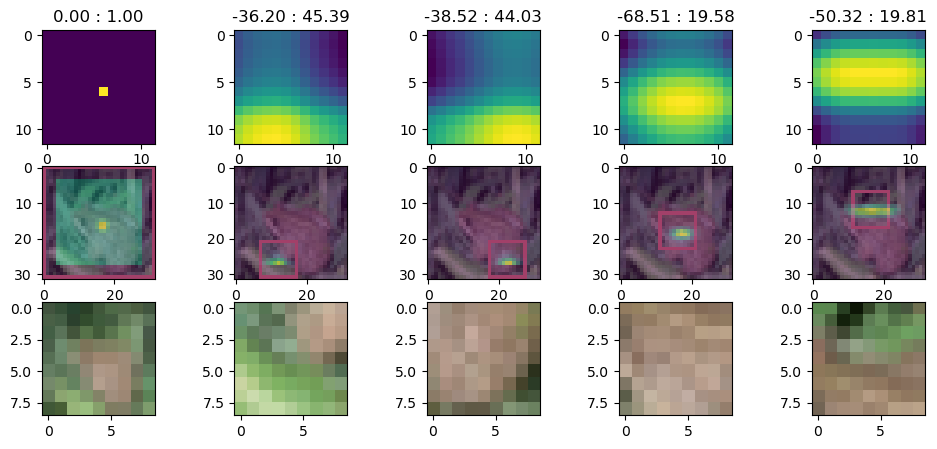

In [24]:
img_h, img_w = imgs.shape[-2:]
fig, axs = plt.subplots(3, len(all_p_next_poses), figsize=(12, 5))
for i, ax in enumerate(axs[0]):
    ax.imshow(all_p_next_poses[i][n].cpu().view(model.grid_sz, model.grid_sz));
    ax.set_title(f"{all_p_next_poses[i][n].min():.02f} : {all_p_next_poses[i][n].max():.02f}");
    
for i, ax in enumerate(axs[1]):
    img = r_imgs[n].cpu().numpy().transpose(1, 2, 0).copy()
    if i == 0:
        py0, px0, py1, px1 = 1, 1, img_h-1, img_w-1
    else:
        py0, px0, py1, px1 = model.pt_coords_ij[all_next_poses[i][n].argmax().item()].cpu().numpy()
    cv2.rectangle(img, (px0-1, py0-1), (px1, py1), (1, 0.5, 0.5), 1)
    ax.imshow(img, cmap='gray', alpha=1.0, vmin=0, vmax=1.0);
    p = model.pt_start + model.pt_sz//2
    tmp = F.interpolate(
        (all_p_next_poses[i][n].cpu()).softmax(-1).view(1, 1, model.grid_sz, model.grid_sz), 
        size=None, scale_factor=model.pt_step,
        mode='bilinear',
        align_corners=True
    )[0, 0]
    t_h, t_w = tmp.shape[-2:]
    tmp2 = np.zeros(imgs[n, 0].shape)
    py0, px0, py1, px1 = p, p, p+t_h, p+t_w
    tmp2[py0:py1, px0:px1] = tmp
    ax.imshow(tmp2, alpha=0.5);    
    
for i, ax in enumerate(axs[2]):
    ax.imshow(all_r_next_patches[i][n].permute(1, 2, 0).cpu(), cmap='gray', vmin=0, vmax=1.0)

In [25]:
import matplotlib.animation as animation
from IPython.display import HTML, Image

In [26]:
def play_glimpses_v1(n):
    def add_title(ax, text):
        return ax.text(0.5, 1.05, text, size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    
    # fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 3))
    gs = axs[0, 0].get_gridspec()
    for ax in axs[:, 0]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, 0])    
    
    img_h, img_w = imgs.shape[-2:]
    a_ans = []
    img = r_imgs[n].cpu()
    visible_img = F.interpolate(all_r_next_patches[0][n].cpu()[None], (img_h, img_w), mode='nearest')[0] 
    axs[0, 1].imshow(img.permute(1, 2, 0), vmin=0, vmax=1),
    for i in range(0, len(all_next_poses)):
        patch = torch.zeros((img_h, img_w))
        if i > 0:
            py0, px0, py1, px1 = model.pt_coords_ij[all_next_poses[i][n].argmax().item()].cpu().numpy() 
            patch[py0:py1, px0:px1] = 1.0
        visible_img = torch.stack([visible_img, (img+0.25)*patch], dim=0).max(0)[0].clamp_(0, 1)
        f_ans = [
            axbig.imshow(visible_img.permute(1, 2, 0), vmin=0, vmax=1),
            axbig.imshow(patch, alpha=0.3, vmin=0, vmax=1),
            axs[1, 1].matshow(F.softmax(all_logits[i:i+1, n], dim=-1).detach().cpu(), vmax=1.0),
            add_title(axs[1, 1], f'{all_logits[i, n].argmax()}: {all_logits[i, n].max().item():.04f}'),
        ]
        
        a_ans.append(f_ans)        
        
    axbig.axis('off')
    axs[0, 1].axis('off')

    axs[1, 1].tick_params(
        axis='both', which='both', reset=True, 
        labelbottom=True, labeltop=False, labelright=False, labelleft=False,
        bottom=True, top=False, left=False, right=False
    )

    axs[1, 1].set_xticks(range(10))

    fig.tight_layout()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.05)    

    ani = animation.ArtistAnimation(fig, a_ans, interval=1000, blit=False, repeat_delay=4000)                             

    plt.close(fig)
    
    return ani

In [27]:
HTML(play_glimpses_v1(36).to_jshtml(default_mode='loop'))

In [28]:
def play_glimpses_v2(n):
    def add_title(ax, text):
        return ax.text(0.5, 1.05, text, size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    
    fig, axs = plt.subplots(2, 3, figsize=(6, 3))
    gs = axs[1, 0].get_gridspec()
    for ax in axs[1, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[1, :])
    
    img_h, img_w = imgs.shape[-2:]
    a_ans = []
    visible_img = F.interpolate(all_r_next_patches[0][n].cpu()[None], (img_h, img_w), mode='nearest')[0]
    img = r_imgs[n].cpu()
    axs[0, 0].imshow(img.permute(1, 2, 0), vmin=0, vmax=1),
    for i in range(0, len(all_next_poses)):
        patch = torch.zeros((img_h, img_w))
        if i > 0:
            py0, px0, py1, px1 = model.pt_coords_ij[all_next_poses[i][n].argmax().item()].cpu().numpy() 
            patch[py0:py1, px0:px1] = 1.0
        visible_img = torch.stack([visible_img, (imgs[n].cpu()+0.25)*patch], dim=0).max(0)[0].clamp_(0, 1)
        f_ans = [
            axs[0, 2].imshow(all_r_next_patches[i][n].permute(1, 2, 0).cpu(), vmin=0, vmax=1),
            axs[0, 1].imshow(visible_img.permute(1, 2, 0), vmin=0, vmax=1),
            axs[0, 1].imshow(patch, alpha=0.3, vmin=0, vmax=1),
            axbig.matshow(F.softmax(all_logits[i:i+1, n], dim=-1).detach().cpu(), vmax=1.0),
            add_title(axbig, f'{all_logits[i, n].argmax()}: {all_logits[i, n].max().item():.04f}'),
        ]
        
        a_ans.append(f_ans)        
        
    axs[0, 0].axis('off')
    axs[0, 1].axis('off')
    axs[0, 2].axis('off')

    axbig.tick_params(
        axis='both', which='both', reset=True, 
        labelbottom=True, labeltop=False, labelright=False, labelleft=False,
        bottom=True, top=False, left=False, right=False
    )

    axbig.set_xticks(range(10))

    fig.tight_layout()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.05)    

    ani = animation.ArtistAnimation(fig, a_ans, interval=1000, blit=False, repeat_delay=4000)                             

    plt.close(fig)
    
    return ani

In [29]:
HTML(play_glimpses_v2(9).to_jshtml(default_mode='loop'))

In [30]:
exp_name

'cifar10_lstm2x512_pt9big_advaug_fulltrain2ep_pt_f128_s5'

In [31]:
ani_output_dir = f"./animations/{exp_name}_v1/"
os.makedirs(ani_output_dir, exist_ok=True)

for b in tqdm(range(imgs.size(0))):
    ani = play_glimpses_v1(b)
    ani.save(os.path.join(ani_output_dir, f"{b}.gif"))
    
ani_output_dir = f"./animations/{exp_name}_v2/"
os.makedirs(ani_output_dir, exist_ok=True)

for b in tqdm(range(imgs.size(0))):
    ani = play_glimpses_v2(b)
    ani.save(os.path.join(ani_output_dir, f"{b}.gif"))    

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
